In [1]:
import torch
import gymnasium as gym
import os
import numpy as np
from utils import ReplayBuffer #from the TD3 article
import matplotlib.pyplot as plt
from myTD3 import TD3
from utils import ReplayBuffer


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env_name="HalfCheetah-v4"

In [3]:
def train_td3():
    # Create save directory
    save_dir = "results"
    os.makedirs(save_dir, exist_ok=True)
    
    # Create environment
    env = gym.make("HalfCheetah-v4")
    eval_env = gym.make("HalfCheetah-v4")
    
    # Set seeds
    seed = 69
    env.reset(seed=seed)
    eval_env.reset(seed=seed+100)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Get environment dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    # Initialize TD3 agent
    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "hidden_layer_param": [256, 256],
        "discount": 0.99,
        "tau": 0.005,
        "policy_noise": 0.2 * max_action,
        "noise_clip": 0.5 * max_action,
        "d": 1 #delayed policy update, set to 1 to make it every step
    }
    policy = TD3(**kwargs)
    
    # Initialize replay buffer
    replay_buffer = ReplayBuffer(state_dim, action_dim, max_size=int(1e6))
    
    # Set training parameters
    max_timesteps = int(1e5)
    start_timesteps = 1000  # Pure exploration steps
    batch_size = 256
    eval_freq = 500
    
    # Arrays to store evaluation results
    eval_returns = []
    eval_timesteps = []
    
    # Start training
    state, _ = env.reset(seed=seed)
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    
    print("Starting training...")
    for t in range(1, max_timesteps + 1):
        episode_timesteps += 1
        
        # Select action with exploration noise
        if t <= start_timesteps:
            # Pure exploration
            action = env.action_space.sample()
        else:
            # TD3 policy with noise
            action = policy.select_action(np.array(state))
        
        # Perform action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Store data in replay buffer
        replay_buffer.add(state, action, next_state, reward, float(done))
        
        state = next_state
        episode_reward += reward
        
        # Train agent after collecting enough samples
        if t > start_timesteps:
            policy.train(replay_buffer, batch_size)
             # Evaluate agent's performance
            if t % eval_freq == 0:
                eval_return = evaluate_policy(policy, eval_env, eval_episodes=10)
                eval_returns.append(eval_return)
                eval_timesteps.append(t)
                print(f"Timestep {t}: Evaluation over 10 episodes: {eval_return['mean']:.2f} ± {eval_return['std']:.2f}")
        
        # Reset environment if episode is done
        if done:
            print(f"Episode {episode_num+1}: Total Reward = {episode_reward:.2f}, Length = {episode_timesteps}")
            state, _ = env.reset()
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1
        
       
        
    
    # Save final policy
    policy.save(f"{save_dir}/td3_final")
    
    # Save evaluation results
    eval_data = {
        'timesteps': np.array(eval_timesteps),
        'returns_mean': np.array([r['mean'] for r in eval_returns]),
        'returns_std': np.array([r['std'] for r in eval_returns])
    }
    np.save(f"{save_dir}/eval_resultseverystep.npy", eval_data)
    
    print("Training completed!")
    return eval_data


# Evaluation function
def evaluate_policy(policy:TD3, env, eval_episodes=10):
    returns = []
    
    for _ in range(eval_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = policy.select_action(np.array(state)) # No exploration noise
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            state = next_state
            
        returns.append(episode_reward)
    
    return {
        'mean': np.mean(returns),
        'std': np.std(returns)
    }

In [4]:
train_td3()

c:\Users\forge\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Starting training...
Episode 1: Total Reward = -348.98, Length = 1000
Timestep 1500: Evaluation over 10 episodes: -416.50 ± 12.70
Timestep 2000: Evaluation over 10 episodes: -550.19 ± 12.92
Episode 2: Total Reward = -412.71, Length = 1000
Timestep 2500: Evaluation over 10 episodes: -376.69 ± 21.84
Timestep 3000: Evaluation over 10 episodes: -441.99 ± 26.37
Episode 3: Total Reward = -407.49, Length = 1000
Timestep 3500: Evaluation over 10 episodes: -331.32 ± 106.23
Timestep 4000: Evaluation over 10 episodes: -440.13 ± 62.10
Episode 4: Total Reward = -444.59, Length = 1000
Timestep 4500: Evaluation over 10 episodes: -421.67 ± 52.59
Timestep 5000: Evaluation over 10 episodes: -281.84 ± 100.27
Episode 5: Total Reward = -288.79, Length = 1000
Timestep 5500: Evaluation over 10 episodes: -338.91 ± 30.92
Timestep 6000: Evaluation over 10 episodes: -316.23 ± 27.66
Episode 6: Total Reward = -368.62, Length = 1000
Timestep 6500: Evaluation over 10 episodes: -321.13 ± 22.15
Timestep 7000: Evaluati

{'timesteps': array([  1500,   2000,   2500,   3000,   3500,   4000,   4500,   5000,
          5500,   6000,   6500,   7000,   7500,   8000,   8500,   9000,
          9500,  10000,  10500,  11000,  11500,  12000,  12500,  13000,
         13500,  14000,  14500,  15000,  15500,  16000,  16500,  17000,
         17500,  18000,  18500,  19000,  19500,  20000,  20500,  21000,
         21500,  22000,  22500,  23000,  23500,  24000,  24500,  25000,
         25500,  26000,  26500,  27000,  27500,  28000,  28500,  29000,
         29500,  30000,  30500,  31000,  31500,  32000,  32500,  33000,
         33500,  34000,  34500,  35000,  35500,  36000,  36500,  37000,
         37500,  38000,  38500,  39000,  39500,  40000,  40500,  41000,
         41500,  42000,  42500,  43000,  43500,  44000,  44500,  45000,
         45500,  46000,  46500,  47000,  47500,  48000,  48500,  49000,
         49500,  50000,  50500,  51000,  51500,  52000,  52500,  53000,
         53500,  54000,  54500,  55000,  55500,  56

In [3]:
from scipy.ndimage import uniform_filter1d
def plot_results(results_file, window_size=5, save_path=None):
    """
    Plot TD3 training results with smoothing and standard deviation visualization.
    
    Args:
        results_file (str): Path to the .npy file containing results
        window_size (int): Size of the smoothing window
        save_path (str, optional): If provided, save the figure to this path
    """
    # Load results
    data = np.load(results_file, allow_pickle=True).item()
    
    timesteps = data['timesteps']
    returns_mean = data['returns_mean']
    returns_std = data['returns_std']
    
    # Apply uniform smoothing
    smoothed_mean = uniform_filter1d(returns_mean, size=window_size)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot mean with fill between for std
    plt.plot(timesteps, smoothed_mean, color='blue', linewidth=2, label='Mean Return (Smoothed)')
    plt.fill_between(
        timesteps, 
        smoothed_mean - returns_std, 
        smoothed_mean + returns_std, 
        alpha=0.2, 
        color='blue',
        label='Standard Deviation'
    )
    
    # Additional plot styling
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('Timesteps', fontsize=12)
    plt.ylabel('Return', fontsize=12)
    plt.title('TD3 Training Performance on HalfCheetah-v4', fontsize=14)
    plt.legend(loc='best')
    
    # Add training details text box
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    textstr = '\n'.join((
        'Training Details:',
        f'Total Timesteps: {int(timesteps[-1])}',
        f'Final Return: {returns_mean[-1]:.2f} ± {returns_std[-1]:.2f}',
        f'Max Return: {np.max(returns_mean):.2f}'
    ))
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()

Figure saved to results/TD3figeverystep.png


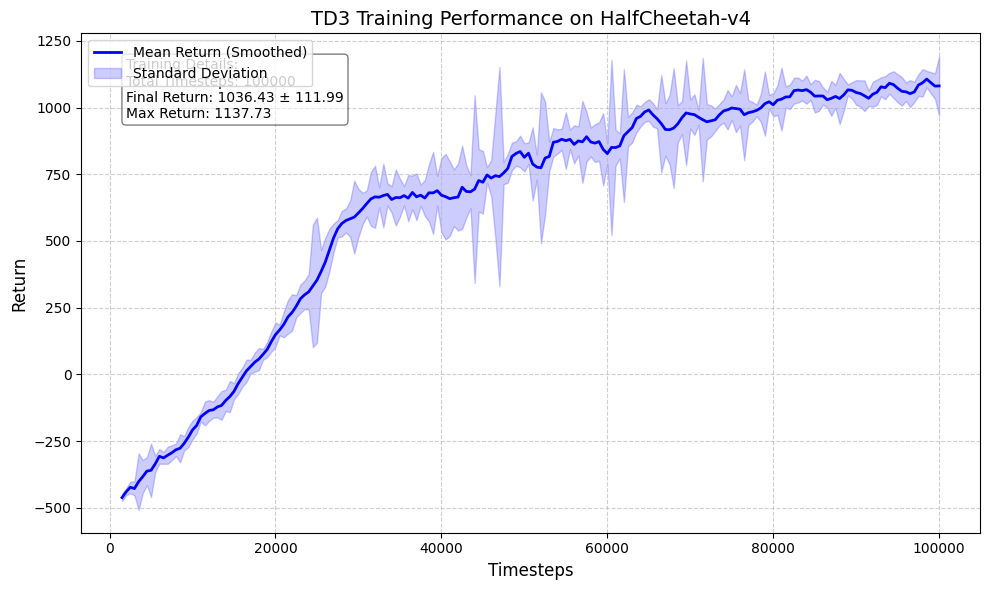

In [4]:
results_files='results/eval_resultseverystep.npy'
save_path='results/TD3figeverystep.png'
plot_results(results_file=results_files,save_path=save_path)